In [1]:
import random
from pathlib import Path

# from napari.utils.notifications import show_info
import matplotlib.pyplot as plt  # Import matplotlib for fallback visualization
import napari
import numpy as np
import pandas as pd
import scipy.ndimage as ndi
from aicsimageio import AICSImage
from cellpose import core, io, models, plot
from matplotlib import cm
from matplotlib.colors import ListedColormap
from natsort import natsorted
# Use scipy.ndimage.label explicitly to avoid namespace conflicts
from scipy.ndimage import binary_dilation
from scipy.ndimage import label
from scipy.ndimage import label as ndi_label
from skimage import measure, morphology
from skimage.feature import peak_local_max
from skimage.filters import gaussian, threshold_otsu
from skimage.measure import label, regionprops
from skimage.segmentation import watershed
from tqdm import trange



Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.4 
platform:       	darwin 
python version: 	3.10.16 
torch version:  	2.7.0! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 




In [2]:
file_name = "/Users/noahwijnheijmer/Library/CloudStorage/OneDrive-HvA/afstuderen/Microscopy Data Huntingtin aggregates/Raw data #1/20240212_CKR_E10B_mHtt-HAQ97doxy48h_BafA1_HA-STAR580_CCCT1-STAR635P_A11-STAR460L_nucspotlive488_3.lif"
img = AICSImage(file_name)

# Print image dimensions to understand the structure
print(f'Image dimensions: {img.dims}')

# Extract channels using AICSImage's get_image_data method
nuclei = img.get_image_data("ZYX", C=0)  # Nuclei
print(f'Nuclei shape: {nuclei.shape}')
CCT1 = img.get_image_data("ZYX", C=1)  # CCT1
print(f'CCT1 shape: {CCT1.shape}')
mHTT = img.get_image_data("ZYX", C=2)  # mHtt
print(f'Aggregate shape: {mHTT.shape}')
# Process aggregates
def process_aggregates(img_channel):
    aggregate_masks = []
    for z_slice in range(img_channel.shape[0]):
        slice_img = img_channel[z_slice]  # Get 2D slice from the aggregate channel
        threshold = 0.6 * np.max(slice_img)
        bright_spots = slice_img > threshold
        clean_mask = morphology.remove_small_objects(bright_spots, min_size=10)
        aggregate_masks.append(clean_mask)
    return aggregate_masks

aggregate_masks = process_aggregates(mHTT)

aggregate_stack = np.stack(aggregate_masks, axis=0)  # shape: (Z, Y, X)

# Print image dimensions to understand the structure
print(f'Image dimensions: {img.dims}')

# Extract channels using AICSImage's get_image_data method
nuclei = img.get_image_data("ZYX", C=0)  # Nuclei
print(f'Nuclei shape: {nuclei.shape}')
CCT1 = img.get_image_data("ZYX", C=1)  # CCT1
print(f'CCT1 shape: {CCT1.shape}')
mHTT = img.get_image_data("ZYX", C=2)  # mHtt
print(f'mHTT shape: {mHTT.shape}')
# Process aggregates
def process_aggregates(img_channel):
    aggregate_masks = []
    for z_slice in range(img_channel.shape[0]):
        slice_img = img_channel[z_slice]  # Get 2D slice from the aggregate channel
        threshold = 0.6 * np.max(slice_img)
        bright_spots = slice_img > threshold
        clean_mask = morphology.remove_small_objects(bright_spots, min_size=10)
        aggregate_masks.append(clean_mask)
    return aggregate_masks

aggregate_masks = process_aggregates(mHTT)

aggregate_stack = np.stack(aggregate_masks, axis=0)  # shape: (Z, Y, X)


Image dimensions: <Dimensions [T: 1, C: 4, Z: 10, Y: 2048, X: 2048]>
Nuclei shape: (10, 2048, 2048)
CCT1 shape: (10, 2048, 2048)
Aggregate shape: (10, 2048, 2048)
Image dimensions: <Dimensions [T: 1, C: 4, Z: 10, Y: 2048, X: 2048]>
Nuclei shape: (10, 2048, 2048)
CCT1 shape: (10, 2048, 2048)
mHTT shape: (10, 2048, 2048)


/var/folders/bm/8qqschwd1n16twnn3s2ywnpm0000gn/T/ipykernel_4124/101700072.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('nipy_spectral', num_labels)


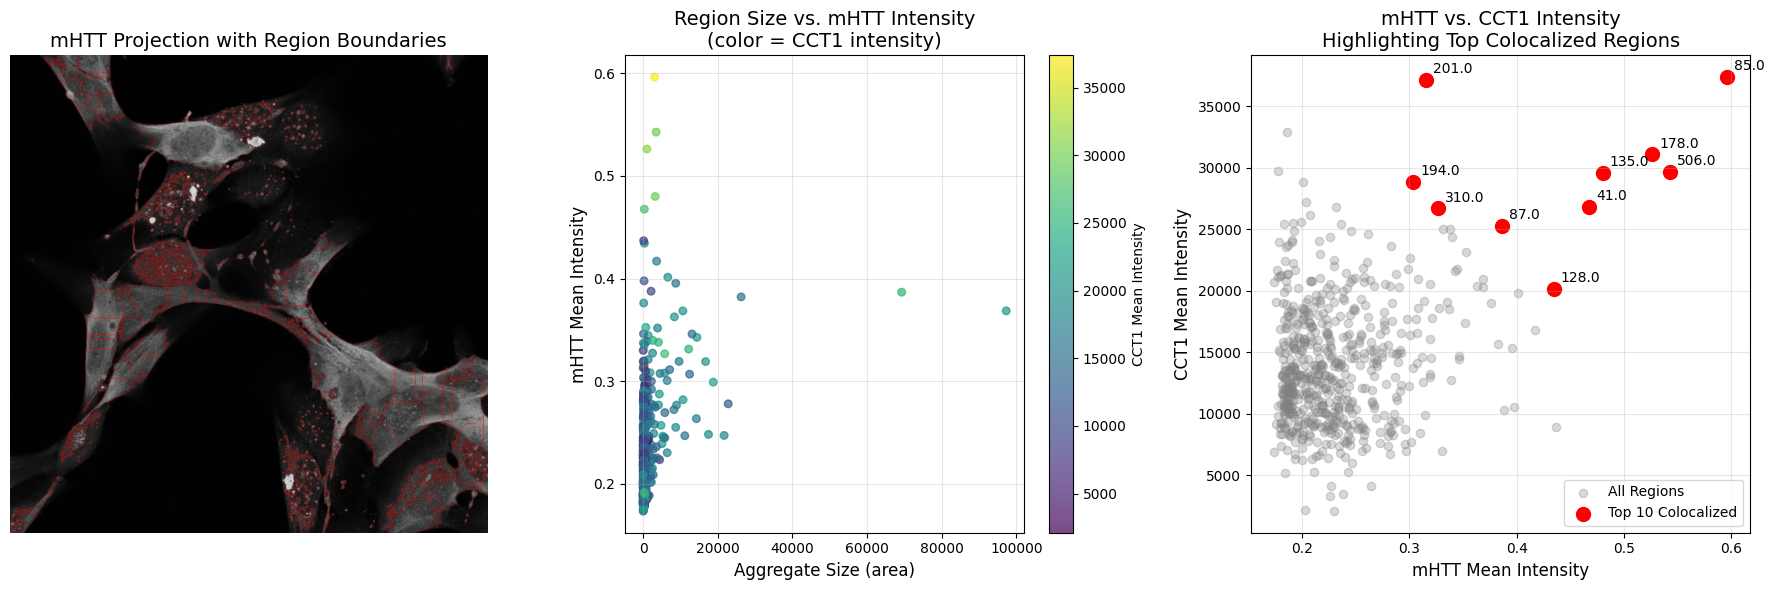

Top 10 regions by colocalization intensity:
 label    area  mHTT_mean_intensity  CCT1_mean_intensity  combined_intensity
    85  3050.0             0.596418         37376.990820        22292.319524
   178   986.0             0.526288         31082.828600        16358.511222
   506  3482.0             0.542776         29644.482769        16090.309578
   135  3219.0             0.480056         29558.884126        14189.919612
    41   304.0             0.467694         26838.986842        12552.430755
   201   294.0             0.315681         37125.578231        11719.841136
    87 69272.0             0.386773         25288.437276         9780.886143
   128   335.0             0.434450         20168.041791         8762.003719
   194   114.0             0.303544         28812.587719         8745.891750
   310  5769.0             0.326728         26696.702028         8722.568891


In [3]:
# Create a 2D maximum intensity projection if working with 3D data
if mHTT.ndim == 3:
    mhtt_proj = mHTT.max(axis=0)
    # Normalize for visualization
    mhtt_norm = (mhtt_proj - mhtt_proj.min()) / (mhtt_proj.max() - mhtt_proj.min())

# Apply Gaussian filter to smooth the image
mhtt_smooth = gaussian(mhtt_norm, sigma=0.7)

# Threshold image
thresh = threshold_otsu(mhtt_smooth)
binary = mhtt_smooth > thresh

# Clean small objects
cleaned = morphology.remove_small_objects(binary, min_size=21)

# Distance transform for watershed
distance = ndi.distance_transform_edt(cleaned)

# Find local maxima
try:
    # For newer scikit-image versions
    local_maxi = peak_local_max(distance, min_distance=10, indices=False, labels=cleaned)
except TypeError:
    # For older scikit-image versions
    coordinates = peak_local_max(distance, min_distance=10, labels=cleaned)
    local_maxi = np.zeros_like(distance, dtype=bool)
    local_maxi[tuple(coordinates.T)] = True
markers = ndi.label(local_maxi)[0]

# Apply watershed to segment touching objects
labels_ws = watershed(-distance, markers, mask=cleaned)

# Prepare dataframe with region properties
props = regionprops(labels_ws, intensity_image=mhtt_norm)
props_cct1 = regionprops(labels_ws, intensity_image=CCT1.max(axis=0) if CCT1.ndim == 3 else CCT1)

# Create combined dataframe
df_combined = pd.DataFrame({
    'label': [p.label for p in props],
    'area': [p.area for p in props],
    'mHTT_mean_intensity': [p.mean_intensity for p in props],
    'CCT1_mean_intensity': [p_cct1.mean_intensity for p_cct1 in props_cct1]
})

# Create a visualization of the segmented regions overlaid on the original images
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original mHTT image with segmentation boundaries
axes[0].imshow(mhtt_norm, cmap='gray')
axes[0].set_title("mHTT Projection with Region Boundaries", fontsize=14)
axes[0].axis('off')

# Show segmented regions with random colors to distinguish them

# Create colormap for labels
num_labels = len(np.unique(labels_ws)) - 1  # Subtract 1 to exclude background
cmap = cm.get_cmap('nipy_spectral', num_labels)
boundary_mask = np.zeros_like(labels_ws, dtype=bool)

# Loop through each labeled region and find its boundaries
for label_id in np.unique(labels_ws)[1:]:  # Skip background (0)
    region = labels_ws == label_id
    boundary = binary_dilation(region) & ~region
    boundary_mask |= boundary

# Create RGB overlay image - gray for the background, colored for regions
overlay_img = np.dstack([mhtt_norm, mhtt_norm, mhtt_norm])
for i in range(3):
    overlay_img[:, :, i][boundary_mask] = 1 if i == 0 else 0  # Red boundaries

# Plot overlay image in the first subplot
axes[0].imshow(overlay_img)

# Scatter plot showing size vs. intensity relationship
scatter = axes[1].scatter(
    df_combined['area'], 
    df_combined['mHTT_mean_intensity'],
    c=df_combined['CCT1_mean_intensity'],
    cmap='viridis',
    alpha=0.7,
    s=30
)
axes[1].set_xlabel('Aggregate Size (area)', fontsize=12)
axes[1].set_ylabel('mHTT Mean Intensity', fontsize=12)
axes[1].set_title('Region Size vs. mHTT Intensity\n(color = CCT1 intensity)', fontsize=14)
fig.colorbar(scatter, ax=axes[1], label='CCT1 Mean Intensity')
axes[1].grid(True, alpha=0.3)

# Highlight top 10 regions by combined intensity (mHTT + CCT1)
df_combined['combined_intensity'] = df_combined['mHTT_mean_intensity'] * df_combined['CCT1_mean_intensity']
top_regions = df_combined.nlargest(10, 'combined_intensity')

# Visualize intensity correlation for top regions
axes[2].scatter(df_combined['mHTT_mean_intensity'], df_combined['CCT1_mean_intensity'], 
                alpha=0.3, color='gray', label='All Regions')
axes[2].scatter(top_regions['mHTT_mean_intensity'], top_regions['CCT1_mean_intensity'], 
                color='red', s=100, label='Top 10 Colocalized')
for i, row in top_regions.iterrows():
    axes[2].annotate(f"{row['label']}", 
                    (row['mHTT_mean_intensity'], row['CCT1_mean_intensity']),
                    xytext=(5, 5), textcoords='offset points')
    
axes[2].set_xlabel('mHTT Mean Intensity', fontsize=12)
axes[2].set_ylabel('CCT1 Mean Intensity', fontsize=12)
axes[2].set_title('mHTT vs. CCT1 Intensity\nHighlighting Top Colocalized Regions', fontsize=14)
axes[2].grid(True, alpha=0.3)
axes[2].legend()

plt.tight_layout()
plt.show()

# Print statistics for top colocalized regions
print("Top 10 regions by colocalization intensity:")
print(top_regions[['label', 'area', 'mHTT_mean_intensity', 'CCT1_mean_intensity', 'combined_intensity']].to_string(index=False))

In [4]:
# Voxel spacing in microns (adjust to match microscope metadata when using different data)
z_spacing = 0.4   # µm per z-slice
xy_spacing = 0.1  # µm per pixel in x and y
scale = (z_spacing, xy_spacing, xy_spacing)

# Define and create aggregate masks if not already available
aggregate_masks = []
for z_slice in range(mHTT.shape[0]):
    slice_img = mHTT[z_slice]  # Get the 2D slice
    # Apply threshold - using a relative value (80% of max) for better detection
    threshold = 0.8 * np.max(slice_img)
    bright_spots = slice_img > threshold
    # Clean up small objects
    clean_mask = morphology.remove_small_objects(bright_spots, min_size=10)
    aggregate_masks.append(clean_mask)

# Stack masks into a 3D volume
aggregate_stack = np.stack(aggregate_masks, axis=0)

# Label the aggregates
labeled_aggregates, num_aggregates = ndi_label(aggregate_stack)
print(f"Found {num_aggregates} mHTT aggregates")

# Threshold the CCT1 channel
CCT1_threshold = threshold_otsu(CCT1)
CCT1_binary = CCT1 > CCT1_threshold
aggregate_binary = labeled_aggregates > 0

# Create overlap mask showing only where CCT1 and aggregates overlap
overlap_mask = CCT1_binary & aggregate_binary

# Create a new labeled array that only includes aggregates where CCT1 signal is present
overlapping_aggregates = np.zeros_like(labeled_aggregates)
overlap_count = 0
overlap_volumes = []
overlap_intensities = []

for label_id in range(1, num_aggregates+1):
    # For each aggregate, keep its label only if it overlaps with CCT1
    aggregate_mask = labeled_aggregates == label_id
    if np.any(aggregate_mask & CCT1_binary):
        overlapping_aggregates[aggregate_mask] = label_id
        overlap_count += 1
        
        # Calculate statistics for this overlapping aggregate
        volume = np.sum(aggregate_mask) * xy_spacing * xy_spacing * z_spacing  # in cubic microns
        overlap_volumes.append(volume)
        
        # Mean intensities
        mHTT_intensity = np.mean(mHTT[aggregate_mask])
        CCT1_intensity = np.mean(CCT1[aggregate_mask])
        overlap_intensities.append((mHTT_intensity, CCT1_intensity))

print(f"Found {overlap_count} aggregates that overlap with CCT1 ({overlap_count/num_aggregates:.1%} of total)")
if overlap_count > 0:
    mean_volume = np.mean(overlap_volumes)
    print(f"Mean volume of overlapping aggregates: {mean_volume:.2f} µm³")


# napari_success = False
# try:
#     import napari
#     # Check if we're in a Jupyter environment
#     import IPython
#     if IPython.get_ipython() is not None:
#         # In Jupyter, use %gui qt magic if available
#         try:
#             IPython.get_ipython().run_line_magic('gui', 'qt')
#         except:
#             pass
    
#     viewer = napari.Viewer()
#     viewer.add_image(nuclei, name="Nuclei", scale=scale)
#     viewer.add_image(CCT1, name="CCT1", colormap="red", blending="additive", scale=scale)
#     viewer.add_image(mHTT, name="mHTT", colormap="green", blending="additive", scale=scale)
#     viewer.add_labels(labeled_aggregates, name="mHTT Aggregates", opacity=0.5, scale=scale)
#     # viewer.add_labels(overlapping_aggregates, name="CCT1-Aggregate Overlap", opacity=0.8, scale=scale)
#     napari_success = True
#     print("Napari visualization successful!")
    
# except Exception as e:
#     print(f"Napari visualization failed: {e}")
#     print("Falling back to matplotlib visualization...")

# # Matplotlib visualization (always run as backup or if napari fails)
# if not napari_success:
#     fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    
#     # Select middle Z-slice for visualization
#     mid_z = labeled_aggregates.shape[0] // 2
    
#     # Row 1: Original channels and overlay
#     im1 = axs[0, 0].imshow(mHTT[mid_z], cmap='viridis')
#     axs[0, 0].set_title(f"mHTT (Z={mid_z})")
#     axs[0, 0].axis('off')
#     plt.colorbar(im1, ax=axs[0, 0], fraction=0.046, pad=0.04)
    
#     im2 = axs[0, 1].imshow(CCT1[mid_z], cmap='magma') 
#     axs[0, 1].set_title(f"CCT1 (Z={mid_z})")
#     axs[0, 1].axis('off')
#     plt.colorbar(im2, ax=axs[0, 1], fraction=0.046, pad=0.04)
    
#     # Overlay image (RGB)
#     overlay_viz = np.zeros((*labeled_aggregates.shape[1:], 3))  # Create RGB image
#     # Normalize for better visualization
#     mHTT_norm = mHTT[mid_z] / np.max(mHTT[mid_z]) if np.max(mHTT[mid_z]) > 0 else 0
#     CCT1_norm = CCT1[mid_z] / np.max(CCT1[mid_z]) if np.max(CCT1[mid_z]) > 0 else 0
#     overlay_viz[:,:,1] = mHTT_norm  # Green for mHTT
#     overlay_viz[:,:,0] = CCT1_norm  # Red for CCT1
#     axs[0, 2].imshow(overlay_viz)
#     axs[0, 2].set_title("Overlay (Red=CCT1, Green=mHTT)")
#     axs[0, 2].axis('off')
    
#     # Row 2: Segmentation results
#     im3 = axs[1, 0].imshow(labeled_aggregates[mid_z], cmap='nipy_spectral')
#     axs[1, 0].set_title(f"All mHTT Aggregates (n={num_aggregates})")
#     axs[1, 0].axis('off')
    
#     im4 = axs[1, 1].imshow(overlapping_aggregates[mid_z], cmap='nipy_spectral')
#     axs[1, 1].set_title(f"Overlapping Aggregates (n={overlap_count})")
#     axs[1, 1].axis('off')
    
#     # If we have overlap data, show a scatter plot of intensities
#     if overlap_intensities:
#         mHTT_ints = [x[0] for x in overlap_intensities]
#         CCT1_ints = [x[1] for x in overlap_intensities]
#         volumes = np.array(overlap_volumes)
        
#         # Size points by volume
#         sizes = 20 + (volumes - np.min(volumes)) / (np.max(volumes) - np.min(volumes) + 1e-10) * 100
        
#         sc = axs[1, 2].scatter(mHTT_ints, CCT1_ints, s=sizes, alpha=0.7, 
#                            c=volumes, cmap='viridis')
#         axs[1, 2].set_xlabel("mHTT Intensity")
#         axs[1, 2].set_ylabel("CCT1 Intensity")
#         axs[1, 2].set_title("Intensity Correlation in Overlapping Regions")
#         cbar = fig.colorbar(sc, ax=axs[1, 2])
#         cbar.set_label('Volume (µm³)')
#     else:
#         axs[1, 2].text(0.5, 0.5, "No overlapping regions found", 
#                    ha='center', va='center', fontsize=12)
#         axs[1, 2].axis('off')
    
#     plt.tight_layout()
#     plt.show()

# Calculate and print colocalization statistics
if overlap_count > 0:
    print("\nColocalization Statistics:")
    print(f"Percentage of mHTT aggregates with CCT1: {overlap_count/num_aggregates:.1%}")
    
    # Calculate Pearson correlation in overlapping regions if available
    if overlap_mask.any():
        from scipy.stats import pearsonr
        mHTT_values = mHTT[overlap_mask].flatten()
        CCT1_values = CCT1[overlap_mask].flatten()
        if len(mHTT_values) > 1:  # Need at least 2 points for correlation
            corr, p_val = pearsonr(mHTT_values, CCT1_values)
            print(f"Pearson correlation in overlapping regions: {corr:.3f} (p={p_val:.3e})")
            
    # Additional statistics
    print(f"\nVolume statistics:")
    print(f"  Total overlapping volume: {np.sum(overlap_volumes):.2f} µm³")
    print(f"  Median volume: {np.median(overlap_volumes):.2f} µm³")
    print(f"  Volume range: {np.min(overlap_volumes):.3f} - {np.max(overlap_volumes):.2f} µm³")

Found 39 mHTT aggregates
Found 34 aggregates that overlap with CCT1 (87.2% of total)
Mean volume of overlapping aggregates: 0.93 µm³

Colocalization Statistics:
Percentage of mHTT aggregates with CCT1: 87.2%
Pearson correlation in overlapping regions: 0.051 (p=3.985e-05)

Volume statistics:
  Total overlapping volume: 31.73 µm³
  Median volume: 0.25 µm³
  Volume range: 0.040 - 3.69 µm³


In [5]:
import napari
import numpy as np
from napari.utils.notifications import show_info
import matplotlib.pyplot as plt  # Import matplotlib for fallback visualization

try:
	# Create a viewer with 3D view
	viewer = napari.Viewer(ndisplay=3)

	# Add nuclei images - check variables are valid numpy arrays first
	if 'nuclei' in locals() and isinstance(nuclei, np.ndarray):
		viewer.add_image(nuclei, name="Nuclei", colormap="gray", scale=scale if 'scale' in locals() else None)
		show_info("Added nuclei data")
	elif 'img_nuclei' in locals() and isinstance(img_nuclei, np.ndarray):
		viewer.add_image(img_nuclei, name="Nuclei", colormap="gray", scale=scale if 'scale' in locals() else None)
		show_info("Added img_nuclei data")

	# Add CCT1 images
	if 'CCT1' in locals() and isinstance(CCT1, np.ndarray):
		viewer.add_image(CCT1, name="CCT1", colormap="red", blending="additive", scale=scale if 'scale' in locals() else None)
		show_info("Added CCT1 data")
	elif 'img_cellbody' in locals() and isinstance(img_cellbody, np.ndarray):
		viewer.add_image(img_cellbody, name="CCT1", colormap="red", blending="additive", scale=scale if 'scale' in locals() else None)
		show_info("Added img_cellbody data")

	# Add mHTT images
	if 'mHTT' in locals() and isinstance(mHTT, np.ndarray):
		viewer.add_image(mHTT, name="mHTT", colormap="green", blending="additive", scale=scale if 'scale' in locals() else None)
		show_info("Added mHTT data")
	elif 'img_aggregate' in locals() and isinstance(img_aggregate, np.ndarray):
		viewer.add_image(img_aggregate, name="mHTT", colormap="green", blending="additive", scale=scale if 'scale' in locals() else None)
		show_info("Added img_aggregate data")
	# Add segmentation labels (ensure they're integer arrays)
	if 'labeled_aggregates' in locals() and isinstance(labeled_aggregates, np.ndarray):
		try:
			# Ensure the labels are integer type for napari
			labeled_aggregates_int = labeled_aggregates.astype(np.int32)
			viewer.add_labels(labeled_aggregates_int, name="mHTT Aggregates", opacity=0.5, scale=scale if 'scale' in locals() else None)
			if labeled_aggregates_int.size > 0: # Avoid error if empty
				show_info(f"Added mHTT label data with {np.max(labeled_aggregates_int)} regions")
			else:
				show_info("Added mHTT label data (empty)")
		except Exception as e:
			show_info(f"Error adding labeled_aggregates: {e}")

	if 'masks_CCT1' in locals() and isinstance(masks_CCT1, np.ndarray):
		try:
			# Ensure the labels are integer type for napari
			masks_CCT1_int = masks_CCT1.astype(np.int32)
			viewer.add_labels(masks_CCT1_int, name="CCT1 Aggregates", opacity=0.5, scale=scale if 'scale' in locals() else None)
			if masks_CCT1_int.size > 0: # Avoid error if empty
				show_info(f"Added CCT1 label data with {np.max(masks_CCT1_int)} regions")
			else:
				show_info("Added CCT1 label data (empty)")
		except Exception as e:
			show_info(f"Error adding CCT1 masks: {e}")
except Exception as e:
	print(f"Error in napari visualization: {e}")
	
	# Create a fallback matplotlib figure if axs is not defined
	if 'axs' not in locals() or not isinstance(axs, np.ndarray):
		fig, axs = plt.subplots(1, 3, figsize=(18, 6))
	
	# Show mHTT data
	if 'mHTT' in locals() and isinstance(mHTT, np.ndarray) and mHTT.ndim == 3:
		# Ensure z_slice is within bounds
		current_z_slice = min(z_slice, mHTT.shape[0] - 1) if 'z_slice' in locals() else 0
		axs[0].imshow(mHTT[current_z_slice], cmap='viridis')
		axs[0].set_title(f"mHTT (Z={current_z_slice})")
	# Show mHTT data
	# Show CCT1 data
	if 'CCT1' in locals() and isinstance(CCT1, np.ndarray) and CCT1.ndim == 3:
		current_z_slice = min(z_slice, CCT1.shape[0] - 1) if 'z_slice' in locals() else 0
		axs[1].imshow(CCT1[current_z_slice], cmap='magma')
		axs[1].set_title(f"CCT1 (Z={current_z_slice})")
	elif 'img_cellbody' in locals() and isinstance(img_cellbody, np.ndarray) and img_cellbody.ndim == 3:
		current_z_slice = min(z_slice, img_cellbody.shape[0] - 1) if 'z_slice' in locals() else 0
		axs[1].imshow(img_cellbody[current_z_slice], cmap='magma')
		axs[1].set_title(f"CCT1 (Z={current_z_slice})")
	
	# Show segmentation masks
	if 'labeled_aggregates' in locals() and isinstance(labeled_aggregates, np.ndarray) and labeled_aggregates.ndim == 3:
		current_z_slice = min(z_slice, labeled_aggregates.shape[0] - 1) if 'z_slice' in locals() else 0
		axs[2].imshow(labeled_aggregates[current_z_slice], cmap='nipy_spectral')
		axs[2].set_title(f"mHTT Segmentation (Z={current_z_slice})")
	elif 'masks_CCT1' in locals() and isinstance(masks_CCT1, np.ndarray) and masks_CCT1.ndim == 3: # Fallback for CCT1 seg if mHTT not available
		current_z_slice = min(z_slice, masks_CCT1.shape[0] - 1) if 'z_slice' in locals() else 0
		axs[2].imshow(masks_CCT1[current_z_slice], cmap='nipy_spectral')
		axs[2].set_title(f"CCT1 Segmentation (Z={current_z_slice})")
	elif 'labeled_mhtt' in locals() and isinstance(labeled_mhtt, np.ndarray) and labeled_mhtt.ndim == 3:
		current_z_slice = min(z_slice, labeled_mhtt.shape[0] - 1) if 'z_slice' in locals() else 0
		axs[2].imshow(labeled_mhtt[current_z_slice], cmap='nipy_spectral')
		axs[2].set_title(f"mHTT Segmentation (Z={current_z_slice})")

	# Update titles - fixed the redundant title setting
	if 'z_slice' in locals():
		axs[1].set_title(f"CCT1 (Z={z_slice})")
		axs[2].imshow(masks_CCT1[current_z_slice], cmap='nipy_spectral')
		axs[2].set_title(f"CCT1 Segmentation (Z={current_z_slice})")

	for ax in axs:
		axs[1].set_title(f"CCT1 (Z={z_slice})")
	
	# Show segmentation masks
	if 'labeled_mhtt' in locals() and isinstance(labeled_mhtt, np.ndarray) and labeled_mhtt.ndim == 3:
		axs[2].imshow(labeled_mhtt[z_slice], cmap='nipy_spectral')
		axs[2].set_title(f"mHTT Segmentation (Z={z_slice})")
	
	for ax in axs:
		ax.axis('off')
	
	plt.tight_layout()
	plt.show()

INFO: Added nuclei data
INFO: Added CCT1 data
INFO: Added mHTT data
INFO: Added mHTT label data with 39 regions
